In [1]:
from qrisp import QuantumVariable, h, x, prepare, conjugate
from qrisp.vqe.problems.heisenberg import create_heisenberg_init_function, heisenberg_problem, create_heisenberg_hamiltonian
import networkx as nx
import numpy as np
import scipy
import matplotlib.pyplot as plt
from run_QITE import run_QITE

import pickle
from time import time
from datetime import datetime

def save_data(data, filename):  
    # Open a file for writing
    with open(filename+'.pickle', 'wb') as file:
        # Write the object to the file
        pickle.dump(data, file)

def load_data(filename):
    with open(filename+'.pickle', 'rb') as file:
        # Load the object from the file
        data = pickle.load(file)
    return data

In [2]:
L = 10
G = nx.Graph()
G.add_edges_from([(k,(k+1)%L) for k in range(L-1)]) 
# nx.draw(G, with_labels=True)

In [64]:
from qrisp.operators import X, Y, Z

J = 1
B = 1
H = create_heisenberg_hamiltonian(G, J, B)
print(H)

# Define scaling factor
F = 10

# Hamiltonian simulation via first order Suzuki-Trotter formula with 5 steps
def exp_H(qv, t):
    H.trotterization(method='commuting')(qv,t/F,5)

O = H.hermitize().eliminate_ladder_conjugates()
commuting_groups = O.group_up(lambda a, b: a.commute(b))
#for group in commuting_groups:
#    print(group)

def trotter_step_2(qarg, t, steps):
    dt = t / steps
    #
    # 1) Forward half-step
    #
    for com_group in commuting_groups:
        with conjugate(com_group.change_of_basis)(qarg, method="commuting") as diagonal_operator:
            intersect_groups = diagonal_operator.group_up(lambda a, b: not a.intersect(b))
            for intersect_group in intersect_groups:
                for term, coeff in intersect_group.terms_dict.items():
                    term.simulate(
                        -coeff * (dt/2) * (-1),
                        qarg
                    )
    
    #
    # 2) Backward half-step (reverse order)
    #
    for com_group in reversed(commuting_groups):
        with conjugate(com_group.change_of_basis)(qarg, method="commuting") as diagonal_operator:
            intersect_groups = diagonal_operator.group_up(lambda a, b: not a.intersect(b))
            for intersect_group in intersect_groups:
                for term, coeff in intersect_group.terms_dict.items():
                    term.simulate(
                        -coeff * (dt/2) * (-1),
                        qarg
                    )

F=10

def exp_H_2(qv, t, steps=2):
    for i in range(steps):
        trotter_step_2(qv, t/F, steps)

X(0)*X(1) + X(1)*X(2) + X(2)*X(3) + X(3)*X(4) + X(4)*X(5) + X(5)*X(6) + X(6)*X(7) + X(7)*X(8) + X(8)*X(9) + Y(0)*Y(1) + Y(1)*Y(2) + Y(2)*Y(3) + Y(3)*Y(4) + Y(4)*Y(5) + Y(5)*Y(6) + Y(6)*Y(7) + Y(7)*Y(8) + Y(8)*Y(9) + Z(0) + Z(0)*Z(1) + Z(1) + Z(1)*Z(2) + Z(2) + Z(2)*Z(3) + Z(3) + Z(3)*Z(4) + Z(4) + Z(4)*Z(5) + Z(5) + Z(5)*Z(6) + Z(6) + Z(6)*Z(7) + Z(7) + Z(7)*Z(8) + Z(8) + Z(8)*Z(9) + Z(9)


In [4]:
H_matrix = H.to_array()
eigvals, eigvecs = np.linalg.eigh(H_matrix)
idx = np.argsort(eigvals)
eigvals_sorted = eigvals[idx].real
print('Eigen energies:', eigvals_sorted)
eigvecs_sorted = eigvecs[:,idx].T
eigvecs_sorted = [vec.reshape(-1,1) for vec in eigvecs_sorted]


Eigen energies: [-17.72269436 -17.03214083 -16.10817429 ...  16.80422607  17.
  19.        ]


# VQE

In [95]:
from qrisp import *
from qrisp.vqe import*

def ansatz(qv,theta):
    [ry(theta[i],qv[i]) for i in range(L)]
    [cx(qv[i],qv[i+1]) for i in range(L-1)]

vqe = VQEProblem(H,ansatz,L)
U_vqe = vqe.train_function(QuantumVariable(H.find_minimal_qubit_amount()),depth=1,max_iter=100)

qv = QuantumVariable(10)
U_vqe(qv)

phi = qv.qs.statevector(return_type="array")
phi = phi/np.linalg.norm(phi)

print(np.abs(np.dot(eigvecs_sorted[0].transpose()[0],phi))**2)
print(np.abs(np.dot(eigvecs_sorted[1].transpose()[0],phi))**2)

0.25274417113533965                                                                  
0.013434099713939385


## QITE 

In [96]:

results = []

results.append(run_QITE(H, U_vqe, exp_H_2, np.linspace(.01,2.0,20), 5, method='GC', use_statevectors=True))

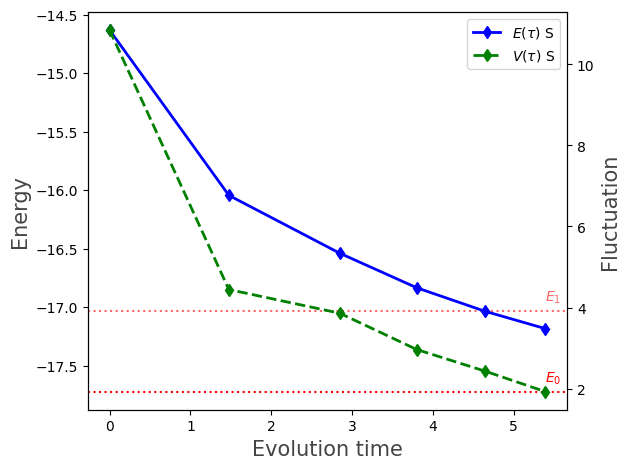

In [98]:

lables_energies=["$E(\\tau)$ S","$E(\\tau)$ S","$E(\\tau)$ VQE","$E(\\tau)$ VQE"]
lables_fluctuations=["$V(\\tau)$ S","$V(\\tau)$ S","$V(\\tau)$ VQE","$V(\\tau)$ VQE"]

alphas = [1.0, 0.6]
markers = ['d','o']

fig, ax1 = plt.subplots()

indices = [0] # GC
beta_max = np.max([np.max(results[i]['evolution_times']) for i in indices])

# 1) Plot energies on the left y-axis
for i,ind in enumerate(indices):
    line1, = ax1.plot(results[ind]['evolution_times'], results[ind]['optimal_energies'], label=lables_energies[ind], color='blue', marker=markers[i], linestyle='solid', linewidth=2, zorder=3, alpha=alphas[i])

ax1.axhline(y=eigvals_sorted[0], color="red", linestyle=':')
ax1.axhline(y=eigvals_sorted[1], color="red", linestyle=':', alpha = 0.6)

ax1.text(
    beta_max,           # shift text slightly to the right
    eigvals_sorted[0]+0.12,             # same y as the line
    r"$E_0$",                           # label for that line
    va="center",
    ha="left",
    color="red",
)
ax1.text(
    beta_max,           # shift text slightly to the right
    eigvals_sorted[1]+0.12,             # same y as the line
    r"$E_1$",                           # label for that line
    va="center",
    ha="left",
    color="red",
    alpha = 0.6
)

ax1.set_xlabel("Evolution time", fontsize=15, color='#444444')
ax1.set_ylabel("Energy", fontsize=15, color='#444444')

# 2) Create a twin axis for fluctuations
ax2 = ax1.twinx()
for i,ind in enumerate(indices):
    line2, = ax2.plot(results[ind]['evolution_times'], results[ind]['variances'], label=lables_fluctuations[ind], color='green', marker=markers[i], linestyle='dashed', linewidth=2, zorder=3, alpha=alphas[i])
ax2.set_ylabel("Fluctuation", fontsize=15, color='#444444')

# 3) Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="best")

#plt.grid()
plt.tight_layout()
#plt.savefig("plots/QITE_rescaled_2nd_B=0.5_GC.pdf")
#plt.savefig("plots/QITE_rescaled_2nd_B=0.5_HOPF.pdf")
plt.show()

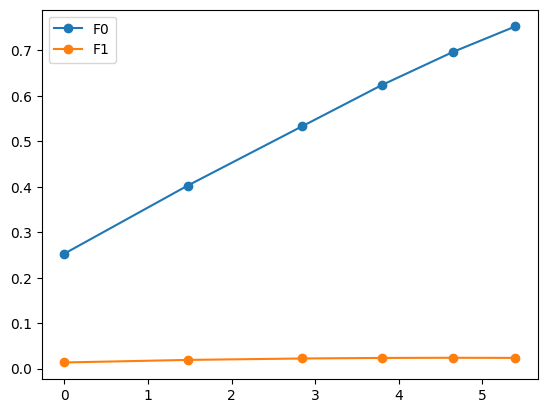

In [99]:
fidelities0 = []
fidelities1 = []

states = results[0]["statevectors"]

for phi in states:
    fidelities0.append(np.abs(np.dot(eigvecs_sorted[0].transpose()[0],phi))**2)
    fidelities1.append(np.abs(np.dot(eigvecs_sorted[1].transpose()[0],phi))**2)

plt.plot(results[0]["evolution_times"],fidelities0,marker='o',label="F0")
plt.plot(results[0]["evolution_times"],fidelities1,marker='o',label="F1")
plt.legend()
plt.show()